---
title: Implementing DBSCAN
description: Implementing DBSCAN for CPU and GPU
date: 2024-01
categories: [PyTorch]
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

This was inspired by a fastai Part 2 assignment by Jeremy Howard.  The main idea is to practice implementing algorithms on a GPU for practice with broadcasting and other key techniques relevant to working on GPUs.

There are 4 Steps
- CPU implementation
- Slower simple GPU implementation
- Somewhat faster simple GPU implementation
- Much faster cuml GPU implementation with brief explanation of what makes it work
- See what replacing only the distance calculation does in my slower GPU implementation

## DBSCAN

### First, check look at the desired behavior using the default implementation

In [ ]:
db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

[0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1
 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1
 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1
 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1
 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1] 200
100 100


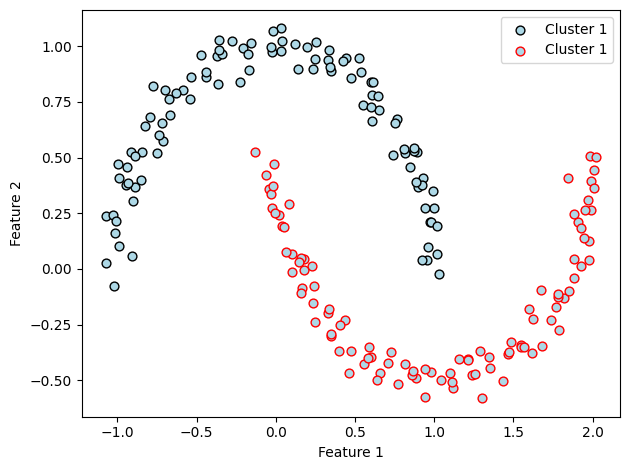

In [ ]:
y_db = db.fit_predict(X)
print(y_db,len(y_db))
print(len(X[y_db == 0, 0]), len(X[y_db == 1, 1]))
plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='lightblue',
            edgecolor='red',
            marker='o',
            s=40,
            label='Cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

### DBSCAN custom implementation

-  A point is a core point if at least a specified number min_samples of neighboring points fall within eps radius
- A *border point* is a point that has fewer than min_samples within eps, but lies within the radius eps of a core point
- All other points that are neither core nor border points are *noise points*

Algorithm
- Label the points as core, border, or noise.
- Form a separate cluster for each core point or connected group of core points.  (Core points are connected if they are no farther away than eps).
- Assign each border point to the cluster of its corresponding core points.

- Want border point to have a reference to its core point for easy merging
- Once merge cluster points, want to go find and update corresponding border points' reference

In [ ]:
class DbscanCustom: #(torch.nn.Module):
    def __init__(self, eps, min_samples):
        super().__init__()
        self.eps = eps
        self.min_samples = min_samples
    def fit_predict(self, X):
        # Label points as core or assign border to core, skip if noise
        self.label_points(X)
        # Form clusters of connected groups of core points
        # Avoid RuntimeError: dictionary changed size during iteration,
        # make a copy of the keys!!!
        keys = list(self.mapping.keys())
        #print(len(keys)+sum([len(v) for _,v in self.mapping.items()]))
        merged = set()
        for idx,i in enumerate(keys[:-1]): # iterating through a list now!
          for j in keys[idx+1:]:
            #if i == j: continue
            if self.distance(i,j) <= self.eps:
              #print(self.mapping[i],self.mapping[j])
              self.mapping[j].add(i) #IN-PLACE
              self.mapping[j]=self.mapping[j].union(self.mapping[i]) #NOT IN-PLACE!!!!!!!!!!
              print(f"Deleting {self.mapping[i]} and i is {i} and self.mapping[j] is {self.mapping[j]}")
              del self.mapping[i]
              merged.add(i)
              break
          #if i in merged: continue
        # Relabel clusters
        print(self.mapping)
        final_map = {i:v for i, (k,v) in enumerate(self.mapping.items())}
        len_pts = len(final_map)+sum([len(v) for _,v in final_map.items()])
        print(final_map, "\n", len_pts)
        return final_map

    def label_points(self, X):
        """1. Label the points as core, border, or noise."""
        self.mapping = {}
        self.X  = X
        self.get_core_points()
        self.get_border_points()
        # Ignore the noise points, don't need them later
    def get_core_points(self):
      for i,x in enumerate(self.X):
            if self.is_core_point(i):
                self.mapping[i] = set()

    def get_border_points(self):
       for i,x in enumerate(X):
            if i not in self.mapping:
                self.map_border(i)

    def is_core_point(self, i):
      # TODO: update to point to itself?
        """A point is a core point if at least a specified number min_samples of neighboring points fall within eps radius"""
        num_within = 0
        for j,x in enumerate(self.X): # TODO: Keys vs indices; straighten up!
          if i == j:
            continue
          if self.distance(i,j) <= self.eps:
              num_within += 1
          if num_within >= self.min_samples:
            #print(X[i],X[j],self.distance(i,j),num_within,self.min_samples)
            return True
        return False
    def map_border(self, i):
      # TODO: update to point to point to its core idx
        """A *border point* is a point that has fewer than min_samples within eps, but lies within the radius eps of a core point"""
        for j in self.mapping:
          if i == j:
            continue
          if self.distance(i,j) <= self.eps:
            self.mapping[j].add(i)
            break


    def distance(self,i,j):
      """Distance between points of self.X with indices i and j"""
      #print(np.sqrt(np.sum((self.X[i]-self.X[j])**2)))
      return np.sqrt(np.sum((self.X[i]-self.X[j])**2))

In [ ]:
class DbscanCustom: #(torch.nn.Module):
    def __init__(self, eps, min_samples):
        super().__init__()
        self.eps = eps
        self.min_samples = min_samples
    def fit_predict(self, X):
        # Label points as core or assign border to core, skip if noise
        self.label_points(X)
        # Form clusters of connected groups of core points
        # Avoid RuntimeError: dictionary changed size during iteration,
        # make a copy of the keys!!!
        keys = list(self.mapping.keys())
        #print(keys)
        #print(len(keys)+sum([len(v) for _,v in self.mapping.items()]))
        merged = set()
        for idx,i in enumerate(keys[:-1]): # iterating through a list now!
          for j in keys[idx+1:]:
            #if i == j: continue
            if self.distance(i,j) <= self.eps:
              #print(self.mapping[i],self.mapping[j])
              self.mapping[j].add(i) #IN-PLACE
              self.mapping[j]=self.mapping[j].union(self.mapping[i]) #NOT IN-PLACE!!!!!!!!!!
              merged.add(i)
          if i in merged:
            #print(f"Deleting {self.mapping[i]} and i is {i} and self.mapping[j] is {self.mapping[j]}")
            del self.mapping[i]
            #break
          #if i in merged: continue
        # Relabel clusters
        print(self.mapping)
        final_map = {i:v for i, (k,v) in enumerate(self.mapping.items())}
        len_pts = len(final_map)+sum([len(v) for _,v in final_map.items()])
        print(final_map, "\n", len_pts)
        return final_map

    def label_points(self, X):
        """1. Label the points as core, border, or noise."""
        self.mapping = {}
        self.X  = X
        self.get_core_points()
        self.get_border_points()
        # Ignore the noise points, don't need them later
    def get_core_points(self):
      for i,x in enumerate(self.X):
            if self.is_core_point(i):
                self.mapping[i] = set()

    def get_border_points(self):
       for i,x in enumerate(X):
            if i not in self.mapping:
                self.map_border(i)

    def is_core_point(self, i):
      # TODO: update to point to itself?
        """A point is a core point if at least a specified number min_samples of neighboring points fall within eps radius"""
        num_within = 0
        for j,x in enumerate(self.X): # TODO: Keys vs indices; straighten up!
          if i == j:
            continue
          if self.distance(i,j) <= self.eps:
              num_within += 1
          if num_within >= self.min_samples:
            #print(X[i],X[j],self.distance(i,j),num_within,self.min_samples)
            return True
        return False
    def map_border(self, i):
      # TODO: update to point to point to its core idx
        """A *border point* is a point that has fewer than min_samples within eps, but lies within the radius eps of a core point"""
        for j in self.mapping:
          if i == j:
            continue
          if self.distance(i,j) <= self.eps:
            self.mapping[j].add(i)
            break


    def distance(self,i,j):
      """Distance between points of self.X with indices i and j"""
      #print(np.sqrt(np.sum((self.X[i]-self.X[j])**2)))
      #print(np.sqrt(np.sum((self.X[20]-self.X[199])**2)))
      return np.sqrt(np.sum((self.X[i]-self.X[j])**2))

- Next, handle border points
- I think the three remaining points are probably border points and need to be mapped to their respective cluster!!!!

In [ ]:
from collections import Counter
class DbscanCustom: #(torch.nn.Module):
    def __init__(self, eps, min_samples):
        super().__init__()
        self.eps = eps
        self.min_samples = min_samples
        self.edges = [] # for union find

    def find(self,i):
      res = i
      while self.parents[res]!=res:
        self.parents[res] = self.parents[self.parents[res]]
        res = self.parents[res]
      return res

    def union(self, i,j):
      pi, pj = self.find(i), self.find(j)
      if pi == pj: return 0, None
      if self.rank[pi] >= self.rank[pj]:
        self.parents[pj] = pi
        self.rank[pi] += self.rank[pj]
        return 1, i
      else:
        self.parents[pi] = pj
        self.rank[pj] += self.rank[pi]
        return 1, j



    def fit_predict(self, X):
        self.parents = list(range(len(X)))
        self.rank = [1]*len(X)
        self.mapping = {}
        self.X = X
        # Label points as core or assign border to core, skip if noise
        self.label_points(X)
        keys = list(self.mapping.keys())
        n = len(keys)
        for i, j in self.edges:
          if i in self.mapping and j in self.mapping:
            res,p = self.union(i,j) #0 or 1, idx
            #if res: n -= 1
            if res and p == i:
              self.mapping[i].update(self.mapping[j])
              #del self.mapping[j]
            elif res and p == j:
              self.mapping[j].update(self.mapping[i])
              #del self.mapping[i]
        print("SELF.MAPPING")
        print(self.mapping)
        print("PARENTS")
        print(self.parents)
        print("Parents len")
        print(len(self.parents))
        print("CLUSTERS")
        print(set(self.parents))
        print("RANKS")
        print(self.rank)
        print(self.parents[3], self.parents[73], self.parents[103])
        final_map = {}
        counts = Counter(self.parents)
        #cluster_rename = {i:v for i,(k,v) in enumerate(counts.items()) if counts[k]>1}
        # print("CLUSTER RENAME")
        # print(cluster_rename)
        result = [np.nan]*len(X)
        all_vals = self.mapping.values()
        for idx,elt in enumerate(self.parents):
          if elt not in final_map:
              final_map[elt] = set()
          if counts[elt]> 1:
            final_map[elt].add(idx)

        v_to_k = {v1:k for k,v in self.mapping.items() for v1 in v if v}
        print("v_to_k")
        print(v_to_k)
        print(final_map)
        print(len(final_map))
        final_map = {i:v for i, (k,v) in enumerate(final_map.items())}
        print(final_map)

        for i,v in final_map.items():
          for j in v:
            result[j] = i
        for v,k in v_to_k.items():
          result[v]  = result[k]
        print(result)
        return np.array(result)

        # final_map = {i:v for i, (k,v) in enumerate(self.mapping.items())}
        # len_pts = len(final_map)+sum([len(v) for _,v in final_map.items()])
        # print(final_map, "\n", len_pts)
        #return final_map

    def label_points(self, X):
        """1. Label the points as core, border, or noise."""
        self.mapping = {}
        self.X  = X
        self.get_core_points()
        self.get_border_points()
        print("EDGES:")
        print(self.edges)
        # Ignore the noise points, don't need them later
    def get_core_points(self):
      for i,x in enumerate(self.X):
            if self.map_core(i):
                self.mapping[i] = set()

    def get_border_points(self):
       for i,x in enumerate(X):
            if i not in self.mapping:
                self.map_border(i)

    def map_core(self, i):
      # TODO: update to point to itself?
        """A point is a core point if at least a specified number min_samples of neighboring points fall within eps radius"""
        num_within = 0
        for j,x in enumerate(self.X): # TODO: Keys vs indices; straighten up!
          if i == j:
            continue
          if self.distance(i,j) <= self.eps:
              self.edges.append([i,j])
              num_within += 1
        if num_within >= self.min_samples:
          return True
        return False
    def map_border(self, i):
      # TODO: update to point to point to its core idx
        """A *border point* is a point that has fewer than min_samples within eps, but lies within the radius eps of a core point"""
        min_dist = self.eps
        min_idx = None
        for j in self.mapping:
          if i == j:
            continue
          if self.distance(i,j) <= self.eps:
            if self.distance(i,j) <= min_dist:
              min_dist = self.distance(i,j)
              min_idx = j
        if min_idx: self.mapping[min_idx].add(i)


    def distance(self,i,j):
      """Distance between points of self.X with indices i and j"""
      #print(np.sqrt(np.sum((self.X[i]-self.X[j])**2)))
      return np.sqrt(np.sum((self.X[i]-self.X[j])**2))

EDGES:
[[0, 8], [0, 30], [0, 34], [0, 55], [0, 63], [0, 77], [0, 114], [0, 119], [0, 120], [0, 139], [0, 152], [0, 192], [1, 44], [1, 67], [1, 96], [1, 108], [1, 151], [1, 163], [1, 168], [1, 180], [1, 183], [1, 199], [2, 33], [2, 39], [2, 76], [2, 84], [2, 105], [2, 122], [2, 124], [2, 141], [2, 149], [2, 194], [3, 53], [3, 106], [3, 171], [4, 5], [4, 12], [4, 26], [4, 62], [4, 95], [4, 96], [4, 135], [4, 151], [4, 165], [4, 183], [4, 199], [5, 4], [5, 12], [5, 20], [5, 26], [5, 27], [5, 52], [5, 62], [5, 80], [5, 95], [5, 117], [6, 8], [6, 15], [6, 37], [6, 46], [6, 86], [6, 91], [6, 114], [6, 126], [6, 130], [6, 139], [6, 145], [6, 193], [7, 21], [7, 32], [7, 49], [7, 54], [7, 74], [7, 79], [7, 167], [7, 169], [7, 175], [7, 187], [8, 0], [8, 6], [8, 15], [8, 30], [8, 63], [8, 77], [8, 91], [8, 114], [8, 120], [8, 130], [8, 139], [8, 152], [8, 192], [8, 193], [9, 13], [9, 32], [9, 54], [9, 57], [9, 64], [9, 100], [9, 134], [9, 136], [9, 156], [9, 161], [9, 169], [9, 175], [10, 31], [

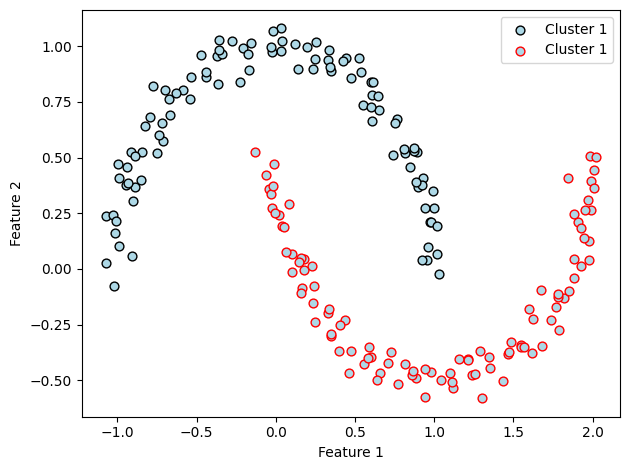

In [ ]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
db_custom = DbscanCustom(eps=0.2, min_samples=5)
y_db = db_custom.fit_predict(X)
plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='lightblue',
            edgecolor='red',
            marker='o',
            s=40,
            label='Cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

- The code below is correct, make it efficient; remove v_to_k by chaning map_border, see if can directly do all the ops on the numpy array
- Then move to GPU, perhaps needing to make less efficient on CPU first by doing all distance calculations (200*200, only need upper triangle) on CPU, then moving over...
- Q: Do I need the mapping?  EOD, just looking at parents...

In this code, np.unique(a) returns an array of the unique elements in a, sorted in ascending order. Then, np.searchsorted(unique_elements, a) returns an array of the same shape as a, where each element of a is replaced by its index in unique_elements. This effectively remaps the elements of a to the range 0 to len(a)-1.

## Final CPU Implementation

- Make a set of core points and a mapping of border points to their core.
- Use union find to label the array of parents, forming clusters of core points or connected groups of core points.
- Label border points with the parents of their corresponding core points.


In [ ]:
from collections import Counter
class DbscanCustom:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.edges = [] # for union find
        self.core_points = set()
        self.border_to_core = {}

    def find(self,i):
      res = i
      while self.parents[res]!=res:
        self.parents[res] = self.parents[self.parents[res]]
        res = self.parents[res]
      return res

    def union(self, i,j):
      pi, pj = self.find(i), self.find(j)
      if pi == pj: return
      if self.rank[pi] >= self.rank[pj]:
        self.parents[pj] = pi
        self.rank[pi] += self.rank[pj]
      else:
        self.parents[pi] = pj
        self.rank[pj] += self.rank[pi]


    def fit_predict(self, X):
        """
        Use union find to label the array of parents, forming clusters of core points or connected groups of core points.
        Label border points with the parents of their corresponding core points.
        """
        self.parents = list(range(len(X)))
        self.rank = [1]*len(X)
        self.X = X
        self.label_points(X)
        for i, j in self.edges:
          if i in self.core_points and j in self.core_points:
            self.union(i,j)

        for border_idx, core_idx in self.border_to_core.items():
          self.parents[border_idx] = self.parents[core_idx]

        result_orig_label = np.array(self.parents)
        unique_elements = np.unique(result_orig_label)
        result_final_label = np.searchsorted(unique_elements,result_orig_label)
        return result_final_label


    def label_points(self, X):
        """1. Label the points as core, border, or noise."""
        self.X  = X
        self.get_core_points()
        self.get_border_points()

    # Ignore the noise points, don't need them later
    def get_core_points(self):
      for i,x in enumerate(self.X):
            if self.map_core(i):
                self.core_points.add(i)

    def get_border_points(self):
       for i,x in enumerate(X):
            if i not in self.core_points:
                self.map_border(i)

    def map_core(self, i):
        """A point is a core point if at least a specified number min_samples of neighboring points fall within eps radius"""
        num_within = 0
        for j,x in enumerate(self.X):
          if i == j:
            continue
          if self.distance(i,j) <= self.eps:
              self.edges.append([i,j])
              num_within += 1
        if num_within >= self.min_samples:
          return True
        return False

    def map_border(self, border_idx):
        """A border point is a point that has fewer than min_samples within eps, but lies within the radius eps of a core point"""
        min_dist = self.eps
        min_idx = None
        for core_idx in self.core_points:
          if border_idx == core_idx:
            continue
          if self.distance(border_idx,core_idx) <= self.eps:
            if self.distance(border_idx,core_idx) <= min_dist:
              min_dist = self.distance(border_idx,core_idx)
              min_idx = core_idx
        if min_idx: self.border_to_core[border_idx] = min_idx

    def distance(self,i,j):
      """Distance between points of self.X with indices i and j"""
      return np.sqrt(np.sum((self.X[i]-self.X[j])**2))


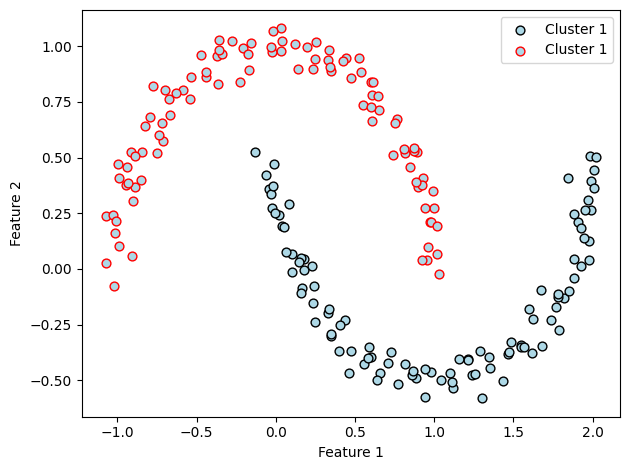

In [ ]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
db_custom = DbscanCustom(eps=0.2, min_samples=5)
y_db = db_custom.fit_predict(X)
plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='lightblue',
            edgecolor='red',
            marker='o',
            s=40,
            label='Cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
%timeit -n 10 db_custom.fit_predict(X)

504 ms ± 220 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Naive GPU implementation (takes more time than CPU implementation)

- Get distance matrix
- Label < min_dist as 1 else 0
- Sum (need min_samples +1 bc of 0 diag for dist between point and itself)
- If sum > min_dist+1, then add to core
- Parallelize computation of cluster labels, not sure how...

In [ ]:
from collections import Counter
class DbscanGPU:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.core_points = set()
        self.border_to_core = {}

    def find(self,i):
      res = i
      while self.parents[res]!=res:
        self.parents[res] = self.parents[self.parents[res]]
        res = self.parents[res]
      return res

    def union(self, i,j):
      pi, pj = self.find(i), self.find(j)
      if pi == pj: return
      if self.rank[pi] >= self.rank[pj]:
        self.parents[pj] = pi
        self.rank[pi] += self.rank[pj]
      else:
        self.parents[pi] = pj
        self.rank[pj] += self.rank[pi]


    def fit_predict(self, X):
        """
        Use union find to label the array of parents, forming clusters of core points or connected groups of core points.
        Label border points with the parents of their corresponding core points.
        """
        self.parents = list(range(len(X)))
        self.rank = [1]*len(X)
        self.X = X
        self.label_points(X)
        #note self.dists is a square matrix
        for i in range(len(self.dists)):
          for j in range(len(self.dists)):
            if self.core_points[i] and self.core_points[j] and self.dists[i,j] <= self.eps:
              self.union(i,j)

        for border_idx, core_idx in self.border_to_core.items():
          self.parents[border_idx] = self.parents[core_idx]

        result_orig_label = np.array(self.parents)
        unique_elements = np.unique(result_orig_label)
        result_final_label = np.searchsorted(unique_elements,result_orig_label)
        return result_final_label


    def label_points(self, X):
        """1. Label the points as core, border, or noise."""
        self.X  = X
        self.calc_distances()
        self.get_core_points()
        self.get_border_points()

    # Ignore the noise points, don't need them later
    def get_core_points(self):
      self.core_points = torch.sum(self.dists<=self.eps,dim = 1)>self.min_samples


    def get_border_points(self):
      self.border_points = set()
      for i,x in enumerate(self.core_points):
        if not x: #if False
          self.border_to_core[i]=self.dists[i][i+1:].argmin().item() + i + 1


    def calc_distances(self):
      """Calculate the distance matrix between a point and every other point"""
      self.dists=(self.X[None,:,:]-self.X[:,None,:]).norm(dim=2)


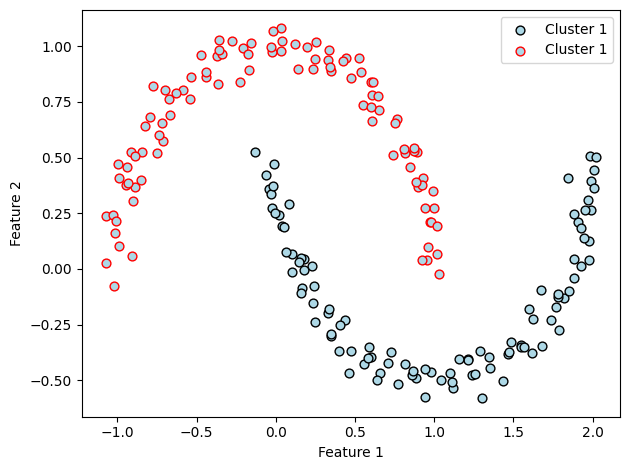

In [ ]:
X, y = map(torch.tensor,make_moons(n_samples=200, noise=0.05, random_state=0))
db_custom_gpu = DbscanGPU(eps=0.2, min_samples=5)
y_db = db_custom_gpu.fit_predict(X)
plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='lightblue',
            edgecolor='red',
            marker='o',
            s=40,
            label='Cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
%timeit -n 10 db_custom_gpu.fit_predict(X)

652 ms ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Simple optimized GPU implementation

GitHub Copilot
Your DBSCAN implementation looks quite good, but there are a few areas where it could be improved for better GPU utilization:

Batching distance calculations: Calculating pairwise distances can be memory-intensive for large datasets. You can batch these calculations to reduce memory usage.

Avoiding Python loops: Python loops are slow and cannot be parallelized on a GPU. You should replace the loops in fit_predict and get_border_points with vectorized operations.

Using in-place operations: In-place operations can reduce memory usage and improve performance. For example, you can use torch.add_ instead of + to update self.rank.

In [ ]:
class DbscanGPU:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

    def fit_predict(self, X):
        # Calculate pairwise distances in batches to save memory
        dists = torch.cdist(X, X)

        # Find core points
        core_points = (dists <= self.eps).sum(dim=1) >= self.min_samples

        # Label each point with its own index initially
        labels = torch.arange(len(X), device=X.device)

        # Union-find for core points
        for i in range(len(X)):
            if core_points[i]:
                for j in range(i + 1, len(X)):
                    if core_points[j] and dists[i, j] <= self.eps:
                        # Find the roots of i and j
                        root_i = self.find(labels, i)
                        root_j = self.find(labels, j)

                        # Union i and j by assigning the smaller label to the larger one
                        if root_i < root_j:
                            labels[root_j] = root_i
                        else:
                            labels[root_i] = root_j

        # Assign each non-core point to the same cluster as its nearest core point
        for i in range(len(X)):
            if not core_points[i]:
                labels[i] = labels[dists[i, core_points].argmin()]

        # Convert labels to consecutive integers starting from 0
        _, labels = torch.unique(labels, return_inverse=True)

        return labels.cpu().numpy()

    @staticmethod
    def find(labels, i):
        if labels[i] != i:
            labels[i] = DbscanGPU.find(labels, labels[i])
        return labels[i]



In [ ]:
class DbscanGPU:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

    def fit_predict(self, X):
        # Calculate pairwise distances in batches to save memory
        dists = torch.cdist(X, X)

        # Find core points
        core_points = (dists <= self.eps).sum(dim=1) >= self.min_samples

        # Label each point with its own index initially
        labels = torch.arange(len(X), device=X.device)

        # Union-find for core points
        for i in range(len(X)):
            if core_points[i]:
                for j in range(i + 1, len(X)):
                    if core_points[j] and dists[i, j] <= self.eps:
                        # Find the roots of i and j
                        root_i = self.find(labels, i)
                        root_j = self.find(labels, j)

                        # Union i and j by assigning the smaller label to the larger one
                        if root_i < root_j:
                            labels[root_j] = root_i
                        else:
                            labels[root_i] = root_j

        # Assign each non-core point to the same cluster as its nearest core point
        for i in range(len(X)):
            if not core_points[i]:
                labels[i] = labels[dists[i, core_points].argmin()]

        # Convert labels to consecutive integers starting from 0
        _, labels = torch.unique(labels, return_inverse=True)

        return labels.cpu().numpy()

    @staticmethod
    def find(labels, i):
        if labels[i] != i:
            labels[i] = DbscanGPU.find(labels, labels[i])
        return labels[i]

    # @staticmethod
    # def find(labels, i):
    #     root = i
    #     while labels[root] != root:
    #         root = labels[root]

    #     # Path compression
    #     while labels[i] != i:
    #         parent = labels[i]
    #         labels[i] = root
    #         i = parent

    #     return root

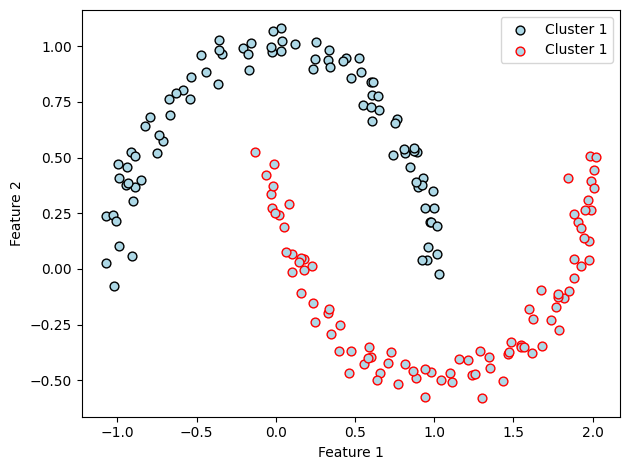

In [ ]:
X, y = map(torch.tensor,make_moons(n_samples=200, noise=0.05, random_state=0))
db_custom_gpu = DbscanGPU(eps=0.2, min_samples=5)
y_db = db_custom_gpu.fit_predict(X)
plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='lightblue',
            edgecolor='red',
            marker='o',
            s=40,
            label='Cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
%timeit -n 10 db_custom_gpu.fit_predict(X)

336 ms ± 45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
(329/504)*100

65.27777777777779

## Out-of-the box optimized DBSCAN implementation

In [1]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==23.12.* dask-cudf-cu12==23.12.* cuml-cu12==23.12.* \
    cugraph-cu12==23.12.* cuspatial-cu12==23.12.* cuproj-cu12==23.12.* \
    cuxfilter-cu12==23.12.* cucim-cu12==23.12.* pylibraft-cu12==23.12.* \
    raft-dask-cu12==23.12.*



In [ ]:
from cuml import DBSCAN as cuml

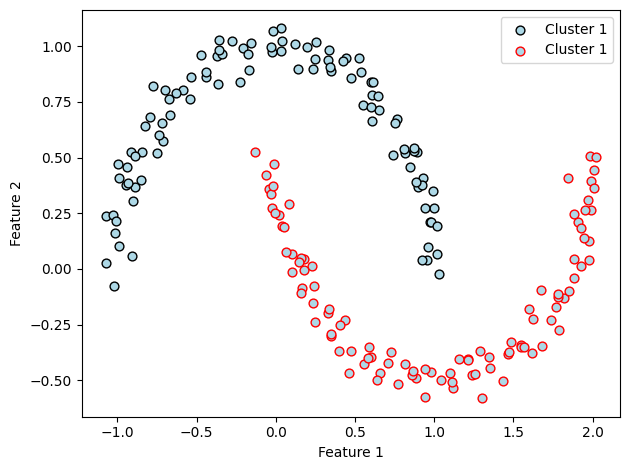

In [ ]:
db_gpu_opt = DBSCAN(eps=0.2, min_samples=5)
y_db = db_gpu_opt.fit_predict(X)
plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='lightblue',
            edgecolor='red',
            marker='o',
            s=40,
            label='Cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
%timeit -n 10 db_gpu_opt.fit_predict(X)

5.7 ms ± 858 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Almost 100x faster on T4!

In [ ]:
X = torch.tensor([[1, 2],[3, 4], [5, 6]])
X
n,m = X.shape
X[None,:,:]-X[:,None,:]

tensor([[[ 0,  0],
         [ 2,  2],
         [ 4,  4]],

        [[-2, -2],
         [ 0,  0],
         [ 2,  2]],

        [[-4, -4],
         [-2, -2],
         [ 0,  0]]])

In [ ]:
X[None,:,:].float()

tensor([[[1., 2.],
         [3., 4.],
         [5., 6.]]])

In [ ]:
X[:,None,:].float()

tensor([[[1., 2.]],

        [[3., 4.]],

        [[5., 6.]]])

In [ ]:
out=(X[None,:,:].float()-X[:,None,:].float()).norm(dim=2)
out

tensor([[0.0000, 2.8284, 5.6569],
        [2.8284, 0.0000, 2.8284],
        [5.6569, 2.8284, 0.0000]])

In [ ]:
eps=0.2
(out <= 0.2).sum(dim=1)

tensor([1, 1, 1])

In [ ]:
X.shape, X[None,:,:].shape, X[:,None,:].shape

(torch.Size([3, 2]), torch.Size([1, 3, 2]), torch.Size([3, 1, 2]))

In [ ]:
(X[None,:,:,None].float()-X[:,:,None].float()).norm(dim=2)

tensor([[[0.],
         [0.],
         [0.]]])

In [ ]:
import math
math.sqrt((1-6)**2)

5.0

In [ ]:
X[None,:,:].shape

torch.Size([1, 3, 2])

In [ ]:
X.T[:,:,None].shape

torch.Size([2, 3, 1])

In [ ]:
torch.sqrt(torch.sum((X[None,:,:]- X.T[:,:,None]) ** 2, dim=(1,)))

tensor([[0.0000, 1.7321],
        [1.7321, 0.0000]])

In [ ]:
torch.sqrt(torch.sum((X[None,:,:]- X.T[:,:,None]) ** 2,dim=(0,1,2)))

tensor(2.4495)

In [ ]:
import torch

def pairwise_distance(matrix):
    # Expand dims to allow broadcasting
    expanded_a = matrix.unsqueeze(1)
    expanded_b = matrix.unsqueeze(0)

    # Compute pairwise distance using Euclidean distance formula
    distances = torch.sqrt(torch.sum((expanded_a - expanded_b) ** 2, dim=-1))

    return distances

# Test the function
matrix = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float)
distances = pairwise_distance(matrix)
print(distances)

tensor([[0.0000, 2.8284, 5.6569],
        [2.8284, 0.0000, 2.8284],
        [5.6569, 2.8284, 0.0000]])


In [ ]:
import torch

def pairwise_distance(matrix):
    # Expand dims to allow broadcasting
    expanded_a = matrix[:,None,:]
    expanded_b = matrix[None,:,:]

    # Compute pairwise distance using Euclidean distance formula
    distances = torch.sqrt(torch.sum((expanded_a - expanded_b) ** 2, dim=-1))

    return distances

# Test the function
matrix = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float)
distances = pairwise_distance(matrix)
print(distances)

tensor([[0.0000, 2.8284, 5.6569],
        [2.8284, 0.0000, 2.8284],
        [5.6569, 2.8284, 0.0000]])


In [ ]:
distances[1].argmin().item()

1

In [ ]:
distances[1,2]

tensor(2.8284)

In [ ]:
math.sqrt((1-5)**2+(2-6)**2)

5.656854249492381

In [ ]:
distances = torch.tensor([[1, 2, 2],[2,3,3],[1,2,1]])
torch.sum(distances>1,dim=1)

tensor([2, 3, 1])

## cuML DBSCAN > Naive GPU DBSCAN

Spatial indexing is a common technique used to speed up DBSCAN implementations. The main idea is to organize the data in such a way that queries about the spatial proximity of data points can be answered more efficiently.

In the context of DBSCAN, one of the most computationally expensive parts of the algorithm is finding all points within a certain distance (eps) of a given point. This is because, in a naive implementation, you would need to calculate the distance between the given point and every other point in the dataset, which is an O(n) operation.

Spatial indexes, such as k-d trees or R-trees, can significantly speed up this operation. These data structures partition the data space into regions, and points within the same region are likely to be close to each other. This allows the algorithm to quickly eliminate many points that are too far away from the given point without having to calculate the exact distance.

In the cuML implementation of DBSCAN, the use of spatial indexing is abstracted away by the underlying CUDA libraries. The VertexDeg::run function, which calculates the degree of each vertex in the adjacency graph representation of the dataset, is likely where the spatial indexing is used. Different algorithms can be used for this calculation based on the algo parameter, some of which may use spatial indexing.

However, it's important to note that while spatial indexing can significantly speed up DBSCAN on CPUs, the situation is a bit different on GPUs. Due to the parallel nature of GPUs, sometimes a brute-force approach (calculating the distance between all pairs of points) can be faster than building and querying a spatial index. The optimal approach depends on the specific characteristics of the GPU and the dataset.